In [35]:
!pip install PyMuPDF
!pip install tqdm


In [36]:
pdf_path = "human-nutrition-text.pdf"

In [37]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text:str) -> str:
  """Perform minor formatting on text."""
  cleaned_text = text.replace("\n", " ").strip()
  return cleaned_text
def open_and_read_pdf(pdf_path: str) -> list[dict]:
  """Open and read a PDF file."""
  doc = fitz.open(pdf_path)
  pages_and_texts = []
  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text=text)
    pages_and_texts.append({"page_number": page_number - 41,
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count": len(text.split(".")),
                            "page_token_count": len(text)/4,
                            "text": text,
                            })

  return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [38]:
import random
random.sample(pages_and_texts, k=4)

[{'page_number': 180,
  'page_char_count': 1072,
  'page_word_count': 195,
  'page_sentence_count': 13,
  'page_token_count': 268.0,
  'text': 'Age Group  Adequate  Intake(mg/day)  Tolerable Upper Intake Level  (mg/day)  Infants (0–6  months)  120  ND  Infants (6–12  months)  370  ND  Children (1–3  years)  1,000  1,500  Children (4–8  years)  1,200  1,900  Children (9–13  years)  1,500  2,200  Adolescents (14–18  years)  1,500  2,300  Adults (19–50  years)  1,500  2,300  Adults (50–70  years)  1,300  2,300  Adults (> 70 years)  1,200  2,300  ND = not  determined  Source: Dietary Reference Intakes: Water, Potassium, Sodium,  Chloride, and Sulfate. Institute of Medicine. http:/ /www.iom.edu/ Reports/2004/Dietary-Reference-Intakes-Water-Potassium- Sodium-Chloride-and-Sulfate.aspx. Updated February 11, 2004.  Accessed September 22, 2017.  Food Sources for Sodium  Most sodium in the typical American diet comes from processed  and prepared foods. Manufacturers add salt to foods to improve  

### Text Processing

Splitting pages into sentences specifically 10 sentencess
# Using spaCy

In [39]:
!pip install spacy

In [40]:
from spacy.lang.en import English

nlp = English()

nlp.add_pipe('sentencizer')

doc = nlp("This is a sentence. this another sentence. I like Elephants")
assert len(list(doc.sents))==3

list(doc.sents)

[This is a sentence., this another sentence., I like Elephants]

In [41]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)

  #check if all sentences are string or not
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]

  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [42]:
random.sample(pages_and_texts, k=1)

[{'page_number': 482,
  'page_char_count': 1372,
  'page_word_count': 223,
  'page_sentence_count': 18,
  'page_token_count': 343.0,
  'text': 'Total energy expenditure is the sum of energy expended at rest,  during digestion, and during physical activity.  The energy required for all the enzymatic reactions that take  place during food digestion and absorption of nutrients is called  the “thermic effect of food” and accounts for about 10 percent of  total energy expended per day. The other energy required during  the day is for physical activity. Depending on lifestyle, the energy  required for this ranges between 15 and 30 percent of total energy  expended. The main control a person has over TEE is to increase  physical activity.  How to Calculate Total Energy Expenditure  Calculating TEE can be tedious, but has been made easier as there  are now calculators available on the Web. TEE is dependent on  age, sex, height, weight, and physical activity level. The equations  are based on s

In [43]:
import pandas as pd

In [44]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,14.18,287.15,10.32
std,348.86,560.44,95.75,9.54,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,8.00,190.69,5.00
50%,562.50,1232.50,215.00,13.00,308.12,10.00
75%,864.25,1605.25,271.25,19.00,401.31,15.00
max,1166.00,2308.00,429.00,82.00,577.00,28.00


In [45]:
 #define split size to turn groups of sentence into chunks
 num_sentences_chunk_size = 10

 #creating a function to split lists of texts recursively into chunk size
 #e.g [30] -> [10,10,10]
 def split_list(input_list: list[str], slice_size: int = num_sentences_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]
 test_list = list(range(25))
 split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [46]:
for item in tqdm(pages_and_texts):
  item['sentence_chunks'] = split_list(input_list=item['sentences'],
                                             slice_size = num_sentences_chunk_size)
  item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [47]:
random.sample(pages_and_texts, k=1)

[{'page_number': 751,
  'page_char_count': 1267,
  'page_word_count': 231,
  'page_sentence_count': 20,
  'page_token_count': 316.75,
  'text': 'with 1 tsp. olive oil,  40  \xa0\xa0\xa0with 1 tsp. sesame seeds  18  ½ c. cooked wild rice  83  \xa0\xa0\xa0with ½ c. chopped kale  18  1 whole-wheat dinner roll  4  \xa0\xa0\xa0with 1 tsp. almond butter  33  691  (Total calories from all meals and  snacks = 1,814)  Discretionary calorie allowance: 186  (Total calories from all meals and snacks = 1,814)  Discretionary calorie allowance: 186  Healthy Eating Index  To assess whether the American diet is conforming to the Dietary  Guidelines, the Center for Nutrition Policy and Promotion (CNPP),  a division of the USDA, uses a standardized tool called the Healthy  Eating Index (HEI)2.  The first HEI was developed in 1995 and revised in 2006. This  tool is a simple scoring system of dietary components. The data for  scoring diets is taken from national surveys of particular population  subgroups,

In [48]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,14.18,287.15,10.32,1.53
std,348.86,560.44,95.75,9.54,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,8.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,13.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,19.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,82.00,577.00,28.00,3.00


# Spilitting each chunk into its own item
We will embed each chunk of sentences into its own numerical representation

In [49]:
import re

pages_and_chunks = []

for item in tqdm(pages_and_texts):
  for sentence_chunk in item["sentence_chunks"]:
    chunk_dict = {}
    chunk_dict["page_number"] = item["page_number"]

    #join the sentences together into a paragraph-like structure aka join list of sentences into one paragraph
    joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
    joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)

    chunk_dict["sentence_chunk"] = joined_sentence_chunk

    #Get Some Stats on our chunks
    chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = -4 chars

    pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)



  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [50]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 635,
  'sentence_chunk': 'Sulfur  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  Sulfur is incorporated into protein structures in the body. Amino  acids, methionine and cysteine contain sulfur which are essential  for the antioxidant enzyme glutathione peroxidase. Some vitamins  like thiamin and biotin also contain sulfur which are important in  regulating acidity in the body. Sulfur is a major mineral with no  recommended intake or deficiencies when protein needs are met. Sulfur is mostly consumed as a part of dietary proteins and sulfur  containing vitamins. Sulfur’s Functional Role  Sulfur is the third most abundant mineral in our body after calcium  and phosphorus.1 Sulfur is incorporated into protein structures in  the body such as keratin in hair and provides stabilization to these  protein structures. One of it’s key roles is the synthesis of 3’- phosphoadenosine-5’phosphosulfate (PAPS)2 which is used in th

In [51]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,750.40,128.29,187.60
std,347.79,455.59,79.84,113.90
min,-41.00,14.00,4.00,3.50
25%,280.50,321.50,51.50,80.38
50%,586.00,764.00,131.00,191.00
75%,890.00,1138.00,194.00,284.50
max,1166.00,1870.00,412.00,467.50


In [52]:
min_token_length = 30
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE',
  'chunk_char_count': 320,
  'chunk_word_count': 54,
  'chunk_token_count': 80.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.',
  'chunk_char_count': 212,
  'chunk_word_count': 32,
  'chunk_token_count': 53.0}]

In [53]:
## 1.56 has been done

# Embedding our texts chunks
Numerical representation of our texts

In [54]:
!pip install sentence-transformers # for embedding models

In [55]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [56]:
#create a list of sentences
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981113e-02  3.03165037e-02 -2.01217793e-02  6.86483830e-02
 -2.55255643e-02 -8.47689249e-03 -2.07147663e-04 -6.32377118e-02
  2.81606149e-02 -3.33353840e-02  3.02634649e-02  5.30720763e-02
 -5.03526479e-02  2.62288153e-02  3.33314016e-02 -4.51578461e-02
  3.63043845e-02 -1.37116178e-03 -1.20171569e-02  1.14946812e-02
  5.04510887e-02  4.70857173e-02  2.11912915e-02  5.14607765e-02
 -2.03746371e-02 -3.58889103e-02 -6.67888962e-04 -2.94393133e-02
  4.95858490e-02 -1.05639603e-02 -1.52013749e-02 -1.31754903e-03
  4.48196754e-02  1.56023391e-02  8.60379942e-07 -1.21397164e-03
 -2.37978995e-02 -9.09372000e-04  7.34479493e-03 -2.53932923e-03
  5.23370057e-02 -4.68043573e-02  1.66214500e-02  4.71579209e-02
 -4.15599570e-02  9.01942665e-04  3.60278897e-02  3.42214778e-02
  9.68227163e-02  5.94828576e-02 -1.64984670e-02 -3.51250097e-02
  5.92516316e-03 -7.07960629e-04 -2.4103

In [57]:
%%time

# running embedding model on cpu
embedding_model.to("cuda")
for item in tqdm(pages_and_chunks_over_min_token_len):
  item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1685 [00:00<?, ?it/s]

CPU times: user 32.4 s, sys: 320 ms, total: 32.7 s
Wall time: 33.6 s


In [58]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [59]:
%%time

#embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)
text_chunk_embeddings

CPU times: user 22.8 s, sys: 50.4 ms, total: 22.8 s
Wall time: 22.9 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

# save embedding to a file

In [60]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [61]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Mā...,797,145,199.25,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,177,244.00,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


# RAG SEARCH AND ANSWERS

RAG Goal: Retrieve relevant passages based on query and use those passages

In [75]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

#import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

#convert embedding from string to array
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

#convert to torch tensors
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis=0), dtype=torch.float32).to("cuda")

#convert text and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,"[0.06742427, 0.09022814, -0.005095489, -0.0317..."
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,"[0.05521564, 0.059213977, -0.016616724, -0.020..."
2,-37,Contents Preface University of Hawai‘i at Mā...,797,145,199.25,"[0.027980184, 0.033981375, -0.020642668, 0.001..."
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,177,244.00,"[0.06825669, 0.0381275, -0.008468541, -0.01813..."
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,"[0.03302645, -0.008497635, 0.009571596, -0.004..."
...,...,...,...,...,...,...
1680,1164,Flashcard Images Note: Most images in the fla...,1329,200,332.25,"[0.018562254, -0.016427767, -0.012704563, -0.0..."
1681,1164,Hazard Analysis Critical Control Points reused...,383,59,95.75,"[0.03347206, -0.057044085, 0.015148939, -0.010..."
1682,1165,ShareAlike 11. Organs reused “Pancreas Organ ...,1312,199,328.00,"[0.07705155, 0.009785576, -0.012181741, 0.0010..."
1683,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,420,69,105.00,"[0.10304516, -0.016470186, 0.008268461, 0.0377..."


In [69]:

embeddings

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       dtype=torch.float64)

In [70]:
embeddings.shape

torch.Size([1685, 768])

In [76]:
#create Model
# !Again
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Embedding model Ready!

Lets Create a Semantic Pipeline
Means search for relavant text and it will find it in document  

In [87]:
# query
query = "macronutrients functions"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# Get Similarity score with dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()
print(f"[Info] Time taken to get scores {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# top-k results
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
[Info] Time taken to get scores 1685 embeddings: 0.00021 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [83]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called  macronutrients. There are three classes of macronutrients:  carbohydrates, lipids, and proteins. These can be metabolically  processed into cellular energy. The energy from macronutrients  comes from their chemical bonds. This chemical energy is  converted into cellular energy that is then utilized to perform work,  allowing our bodies to conduct their basic functions. A unit of  measurement of food energy is the calorie. On nutrition food labels  the amount given for “calories” is actually equivalent to each calorie  multiplied by one thousand. A kilocalorie (one thousand calories,  denoted with a small “c”) is synonymous with the “Calorie” (with a  capital “C”) on nutrition food labels. Water is also a macronutrient in  the sense that you require a large amount of it, but unlike the other  macronutrients, it does not yield calories. Carbohydrates  Carbohydrates are mo

In [88]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [89]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called
macronutrients. There are three classes of macronutrients:  carbohydrates,
lipids, and proteins. These can be metabolically  processed into cellular
energy. The energy from macronutrients  comes from their chemical bonds. This
chemical energy is  converted into cellular energy that is then utilized to
perform work,  allowing our bodies to conduct their basic functions. A unit of
measurement of food energy is the calorie. On nutrition food labels  the amount
given for “calories” is actually equivalent to each calorie  multiplied by one
thousand. A kilocalorie (one thousand calories,  denoted with a small “c”) is
synonymous with the “Calorie” (with a  capital “C”) on nutrition food labels.
Water is also a macronutrient in  the sense that you require a large amount of
it, but unlike the other  macronutrients, it does not yield calories.
Carbohydrate

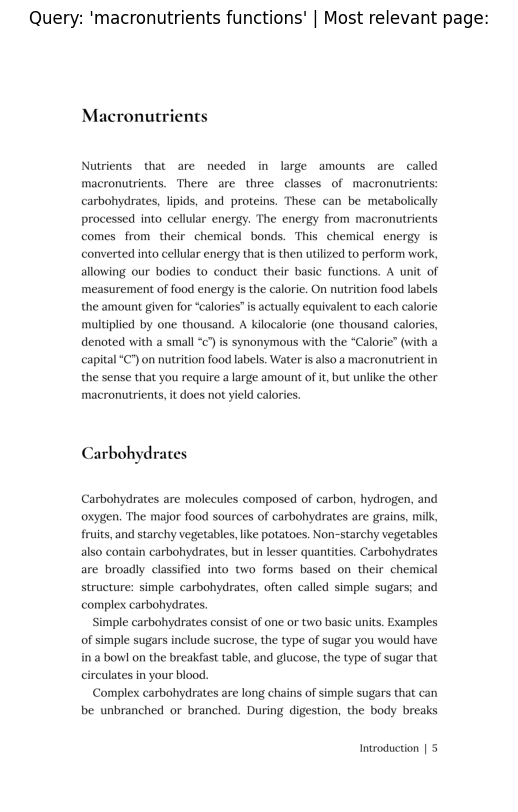

In [90]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

## similarity measures
#### dot_product or cosine similarity

In [93]:
import torch

def dot_product(vector1, vector2):
  return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
  dot = torch.dot(vector1, vector2)
  norm1 = torch.sqrt(torch.sum(vector1**2))
  norm2 = torch.sqrt(torch.sum(vector2**2))
  return dot/ (norm1*norm2)


In [94]:
# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)
